In this notebook we run several experiments for LAFTR, and show the usage of our architecture. We first start with some toy tests, and then run the actual experiments for different values of $\gamma$.

In [1]:
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, CrossEntropyLoss, Sequential
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

from data import BiasedCifar10, BiasedBinaryMNIST
from models import MLPEncoder, ConvEncoderMNIST, ConvEncoderCIFAR, Classifier, Adversary
from train import Trainer
from predict import Predictor

from experiments import run_experiments, generate_p_y_a, create_datasets

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cpu


## First tests

In [5]:
def generate_p_y_a(bias, C, K):
    if bias >= 1.0:
        raise ValueError("bias has to be in the interval [0, 1)")
        
    p_y_a = torch.zeros(C, K)

    dominant_classes = torch.randperm(C)[:K]

    for j in range(K):
        
        uniform = torch.full((C,), 1.0 / C, device=device)
        
        one_hot = torch.zeros(C, device=device)
        one_hot[dominant_classes[j].item()] = 1.0
        
        p_y_a[:, j] = (1 - bias) * uniform + bias * one_hot

    return p_y_a

def entropy(p):
    mask = p > 0
    return -(p[mask] * torch.log2(p[mask])).sum()

def nmi(p_y_a, p_a):
    K, C = p_y_a.shape
    
    p_joint = p_a[:, None] * p_y_a
    p_y = p_joint.sum(dim=0)

    mi_matrix = torch.zeros_like(p_joint)
    ratio = p_y_a / p_y
    mi_matrix[p_joint > 0] = p_joint[p_joint > 0] * torch.log2(ratio[p_joint > 0])
    mi = mi_matrix.sum()

    H_y = entropy(p_y)
    H_a = entropy(p_a)

    nmi = mi / torch.sqrt(H_y * H_a) if H_y > 0 and H_a > 0 else torch.tensor(0.0)
    return nmi

In [6]:
data_dir = os.path.join(project_root, "data/datasets")
C = 10
K = 10

p_y_a = generate_p_y_a(0, C, K)

train_set = BiasedCifar10(data_dir, p_y_a, train=True, device=device)
test_set = BiasedCifar10(data_dir, generate_p_y_a(0.0, C, K), train=False, device=device)

# train_set = BinaryColoredMNIST(data_dir, 0.9, 0.1, device=device)
# test_set = BinaryColoredMNIST(data_dir, 0.5, 0.5, train=False, device=device)

# train_set = BiasedBinaryMNIST(data_dir, p_y_a, train=True, device=device, download=True)
# test_set = BiasedBinaryMNIST(data_dir, generate_p_y_a(0.0, C, K), train=False, device=device, download=True)

# print(f"NormalizedMutualInformation(Y; A) = {nmi(train_set.p_y_a, train_set.p_a):.4f}")

In [7]:
# train_set, val_set = random_split(train_set, [0.8, 0.2])

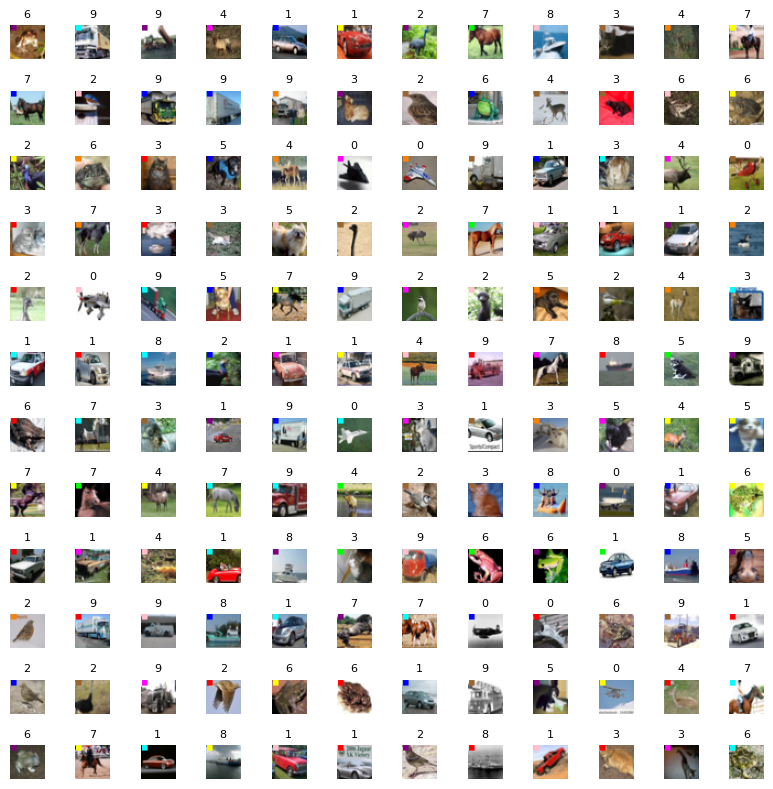

In [8]:
data = train_set[:144]

plt.figure(figsize=(8, 8))

for i, (img, a, label) in enumerate(zip(*data)):
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title(str(label.item()), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
# Setup for DP
latent_dim = 24

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
val_loader = None

encoder = ConvEncoderCIFAR(latent_dim)
classifier = Classifier(latent_dim, C=C)
adversary = Adversary(latent_dim, K=K)

trainer = Trainer(train_loader, encoder, classifier, adversary, C, K, device)

In [11]:
gamma = 0
learning_rate = 1e-3
epochs = 20

criterion_class = CrossEntropyLoss()
optimizer_enc_class = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate, weight_decay=5e-4)
optimizer_adv = Adam(adversary.parameters(), lr=learning_rate, weight_decay=5e-4)

losses_enc, losses_adv = trainer.train(criterion_class, optimizer_enc_class, optimizer_adv, gamma, epochs, True)

  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 1 (encoder+classifier loss: 1.7102, adversary loss: 7.8448)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 2 (encoder+classifier loss: 1.3496, adversary loss: 7.5952)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 3 (encoder+classifier loss: 1.2114, adversary loss: 7.4992)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 4 (encoder+classifier loss: 1.1183, adversary loss: 7.4528)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 5 (encoder+classifier loss: 1.0537, adversary loss: 7.3963)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 6 (encoder+classifier loss: 1.0036, adversary loss: 7.3233)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 7 (encoder+classifier loss: 0.9605, adversary loss: 7.3684)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 8 (encoder+classifier loss: 0.9214, adversary loss: 7.3359)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 9 (encoder+classifier loss: 0.8910, adversary loss: 7.3567)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 10 (encoder+classifier loss: 0.8641, adversary loss: 7.3355)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 11 (encoder+classifier loss: 0.8408, adversary loss: 7.3031)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 12 (encoder+classifier loss: 0.8160, adversary loss: 7.3047)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 13 (encoder+classifier loss: 0.7968, adversary loss: 7.2756)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 14 (encoder+classifier loss: 0.7755, adversary loss: 7.2990)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 15 (encoder+classifier loss: 0.7585, adversary loss: 7.2543)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 16 (encoder+classifier loss: 0.7463, adversary loss: 7.3030)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 17 (encoder+classifier loss: 0.7294, adversary loss: 7.3478)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 18 (encoder+classifier loss: 0.7155, adversary loss: 7.3256)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 19 (encoder+classifier loss: 0.7020, adversary loss: 7.3094)


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 20 (encoder+classifier loss: 0.6896, adversary loss: 7.3646)


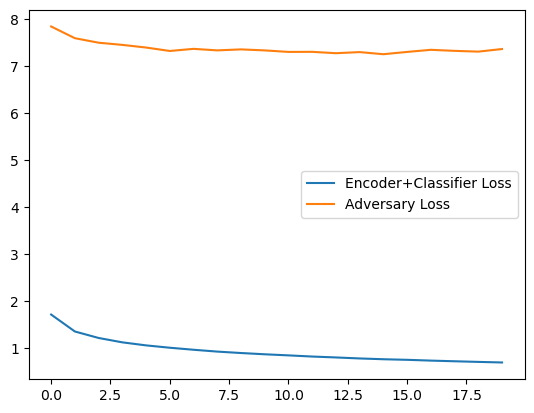

In [12]:
plt.plot(losses_enc, label="Encoder+Classifier Loss")
plt.plot(losses_adv, label="Adversary Loss")

plt.legend()
plt.show()

In [13]:
predict_adversary = Predictor(model=adversary, N=K)
predict_classifier = Predictor(model=classifier, N=C)

x, a_true, y_true = test_set.dataset

z = encoder(x)

a_pred = predict_adversary.predict_class(z, y_true)
y_pred = predict_classifier.predict_class(z)

In [14]:
print("Classifier:")
predict_classifier.print_classification_report(y_true, y_pred)

print()
print()

print("Adversary:")
predict_adversary.print_classification_report(a_true, a_pred)

Classifier:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      1000
           1       0.76      0.70      0.73      1000
           2       0.52      0.46      0.48      1000
           3       0.41      0.44      0.42      1000
           4       0.52      0.53      0.52      1000
           5       0.52      0.50      0.51      1000
           6       0.64      0.70      0.67      1000
           7       0.63      0.64      0.64      1000
           8       0.72      0.75      0.74      1000
           9       0.70      0.67      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



Adversary:
              precision    recall  f1-score   support

           0       0.16      0.51      0.24      1035
           1       0.20      0.37      0.26      1036
           2       0.00      0.00      0.00       984

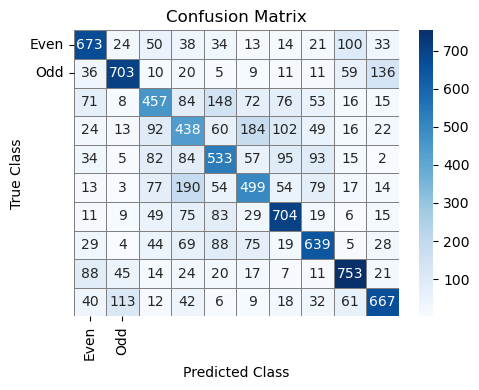

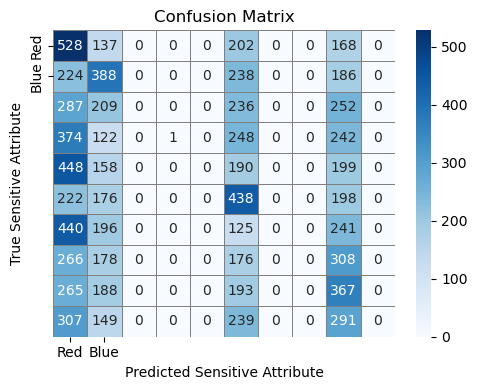

In [15]:
class_cm = predict_classifier.plot_confusion_matrix(y_true, y_pred, labels_names=['Even', 'Odd'], ylabel='True Class', xlabel='Predicted Class') 

adv_cm = predict_adversary.plot_confusion_matrix(a_true, a_pred, labels_names=['Red', 'Blue'], ylabel='True Sensitive Attribute', xlabel='Predicted Sensitive Attribute')

## Baseline model - 0.6

In [4]:
C = 10
K = 10
bias = 0.6
dataset_name = 'CIFAR10'

train_set, test_set_same_bias, test_set_no_bias, test_set_modified_bias = create_datasets(C, K, bias=bias, dataset_name=dataset_name, device=device)

In [5]:
batch_size = 1<<12

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader_same_bias = DataLoader(test_set_same_bias, batch_size=batch_size)

In [6]:

learning_rate = 1e-3
n_epochs = 10
latent_dim = 24

if dataset_name == "MNIST":
    encoder = MLPEncoder(latent_dim).to(device)
    #encoder = ConvEncoder(in_channels=1)
elif dataset_name == "CIFAR10":
    encoder = ConvEncoderCIFAR(latent_dim).to(device)
    
classifier = Classifier(latent_dim, C=C).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

model = torch.nn.Sequential(encoder, classifier)

In [7]:
# training loop
model.train()

for epoch in range(n_epochs):
    for images, _, labels in train_loader:
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 1.554943
Epoch 2 complete: Loss = 1.322280
Epoch 3 complete: Loss = 1.196748
Epoch 4 complete: Loss = 1.121804
Epoch 5 complete: Loss = 1.095317
Epoch 6 complete: Loss = 0.986794
Epoch 7 complete: Loss = 0.965882
Epoch 8 complete: Loss = 0.958760
Epoch 9 complete: Loss = 0.859454
Epoch 10 complete: Loss = 0.855165


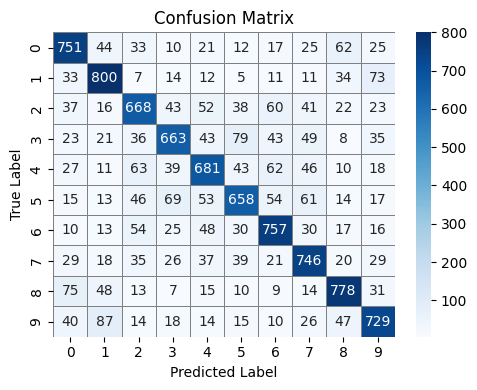

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1000
           1       0.75      0.80      0.77      1000
           2       0.69      0.67      0.68      1000
           3       0.73      0.66      0.69      1000
           4       0.70      0.68      0.69      1000
           5       0.71      0.66      0.68      1000
           6       0.73      0.76      0.74      1000
           7       0.71      0.75      0.73      1000
           8       0.77      0.78      0.77      1000
           9       0.73      0.73      0.73      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



In [8]:

model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_same_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

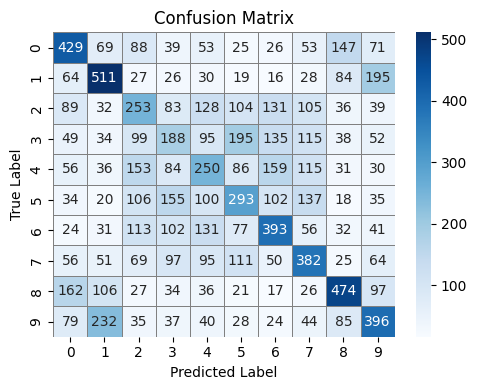

              precision    recall  f1-score   support

           0       0.41      0.43      0.42      1000
           1       0.46      0.51      0.48      1000
           2       0.26      0.25      0.26      1000
           3       0.22      0.19      0.20      1000
           4       0.26      0.25      0.26      1000
           5       0.31      0.29      0.30      1000
           6       0.37      0.39      0.38      1000
           7       0.36      0.38      0.37      1000
           8       0.49      0.47      0.48      1000
           9       0.39      0.40      0.39      1000

    accuracy                           0.36     10000
   macro avg       0.35      0.36      0.35     10000
weighted avg       0.35      0.36      0.35     10000



In [9]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_no_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

In [16]:
baseline_acc = (y_true == y_pred).float().mean().item()
print(f"{100 * baseline_acc:.2f}%")

35.69%


## Experiments - 0.6

In [17]:
C = 10
K = 10
bias = 0.6
encoder_type = 'MLP'
dataset_name = 'CIFAR10'
gammas = [0] + torch.logspace(-6, 0, steps=24).tolist()
device = device

print(gammas)

[0, 9.999999974752427e-07, 1.8233480432172655e-06, 3.324597855680622e-06, 6.0618990573857445e-06, 1.105295177694643e-05, 2.015337668126449e-05, 3.6746620025951415e-05, 6.700187805108726e-05, 0.00012216773757245392, 0.00022275430092122406, 0.00040615859325043857, 0.0007405684445984662, 0.001350314007140696, 0.0024620923213660717, 0.004489251412451267, 0.008185467682778835, 0.014924955554306507, 0.027213387191295624, 0.04961947724223137, 0.09047356992959976, 0.16496481001377106, 0.3007882535457611, 0.5484416484832764, 1.0]


In [18]:
generate_p_y_a(bias, C, K, device)

tensor([[0.0400, 0.0400, 0.0400, 0.6400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.6400, 0.0400, 0.0400, 0.0400,
         0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.6400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.6400, 0.0400, 0.0400,
         0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.6400,
         0.0400],
        [0.6400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.6400, 0.0400,
         0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.6400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.0400],
        [0.0400, 0.6400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.0400],
        [0.0400, 0.0400, 0.6400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
         0.0400]])

In [19]:
results_matrix = run_experiments(C, K, bias, encoder_type, dataset_name, gammas, device)

Trained LAFTR on DP : 1/25.
Trained LAFTR on EO : 1/25.
Trained LAFTR on DP : 2/25.
Trained LAFTR on EO : 2/25.
Trained LAFTR on DP : 3/25.
Trained LAFTR on EO : 3/25.
Trained LAFTR on DP : 4/25.
Trained LAFTR on EO : 4/25.
Trained LAFTR on DP : 5/25.
Trained LAFTR on EO : 5/25.
Trained LAFTR on DP : 6/25.
Trained LAFTR on EO : 6/25.
Trained LAFTR on DP : 7/25.
Trained LAFTR on EO : 7/25.
Trained LAFTR on DP : 8/25.
Trained LAFTR on EO : 8/25.
Trained LAFTR on DP : 9/25.
Trained LAFTR on EO : 9/25.
Trained LAFTR on DP : 10/25.
Trained LAFTR on EO : 10/25.
Trained LAFTR on DP : 11/25.
Trained LAFTR on EO : 11/25.
Trained LAFTR on DP : 12/25.
Trained LAFTR on EO : 12/25.
Trained LAFTR on DP : 13/25.
Trained LAFTR on EO : 13/25.
Trained LAFTR on DP : 14/25.
Trained LAFTR on EO : 14/25.
Trained LAFTR on DP : 15/25.
Trained LAFTR on EO : 15/25.
Trained LAFTR on DP : 16/25.
Trained LAFTR on EO : 16/25.
Trained LAFTR on DP : 17/25.
Trained LAFTR on EO : 17/25.
Trained LAFTR on DP : 18/25.
Tra

In [28]:
C = 10
K = 10
bias = 0.6
encoder_type = 'MLP'
dataset_name = 'CIFAR10'
gammas = [0] + torch.logspace(-5, 1, steps=24).tolist()
device = device

print(gammas)

[0, 9.999999747378752e-06, 1.823348065954633e-05, 3.324597855680622e-05, 6.0618989664362743e-05, 0.00011052951595047489, 0.0002015337668126449, 0.0003674661857075989, 0.0006700187223032117, 0.0012216774048283696, 0.002227542921900749, 0.004061585757881403, 0.007405684795230627, 0.013503140769898891, 0.02462092414498329, 0.04489251226186752, 0.0818546712398529, 0.14924955368041992, 0.27213388681411743, 0.4961947500705719, 0.9047357439994812, 1.6496480703353882, 3.007882595062256, 5.484416484832764, 10.0]


In [29]:
results_matrix2 = run_experiments(C, K, bias, encoder_type, dataset_name, gammas, device)

Trained LAFTR on DP : 1/25.
Trained LAFTR on EO : 1/25.
Trained LAFTR on DP : 2/25.
Trained LAFTR on EO : 2/25.
Trained LAFTR on DP : 3/25.
Trained LAFTR on EO : 3/25.
Trained LAFTR on DP : 4/25.
Trained LAFTR on EO : 4/25.
Trained LAFTR on DP : 5/25.
Trained LAFTR on EO : 5/25.
Trained LAFTR on DP : 6/25.
Trained LAFTR on EO : 6/25.
Trained LAFTR on DP : 7/25.
Trained LAFTR on EO : 7/25.
Trained LAFTR on DP : 8/25.
Trained LAFTR on EO : 8/25.
Trained LAFTR on DP : 9/25.
Trained LAFTR on EO : 9/25.
Trained LAFTR on DP : 10/25.
Trained LAFTR on EO : 10/25.
Trained LAFTR on DP : 11/25.
Trained LAFTR on EO : 11/25.
Trained LAFTR on DP : 12/25.
Trained LAFTR on EO : 12/25.
Trained LAFTR on DP : 13/25.
Trained LAFTR on EO : 13/25.
Trained LAFTR on DP : 14/25.
Trained LAFTR on EO : 14/25.
Trained LAFTR on DP : 15/25.
Trained LAFTR on EO : 15/25.
Trained LAFTR on DP : 16/25.
Trained LAFTR on EO : 16/25.
Trained LAFTR on DP : 17/25.
Trained LAFTR on EO : 17/25.
Trained LAFTR on DP : 18/25.
Tra

## Baseline model - 0.3

In [5]:
C = 10
K = 10
bias = 0.3
dataset_name = 'CIFAR10'

train_set, test_set_same_bias, test_set_no_bias, test_set_modified_bias = create_datasets(C, K, bias=bias, dataset_name=dataset_name, device=device)

In [6]:
batch_size = 1<<12

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader_same_bias = DataLoader(test_set_same_bias, batch_size=batch_size)

In [7]:
learning_rate = 1e-3
n_epochs = 10
latent_dim = 24

if dataset_name == "MNIST":
    encoder = MLPEncoder(latent_dim).to(device)
    #encoder = ConvEncoder(in_channels=1)
elif dataset_name == "CIFAR10":
    encoder = ConvEncoderCIFAR(latent_dim).to(device)
    
classifier = Classifier(latent_dim, C=C).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

model = torch.nn.Sequential(encoder, classifier)

In [8]:
# training loop
model.train()

for epoch in range(n_epochs):
    for images, _, labels in train_loader:
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 1.541344
Epoch 2 complete: Loss = 1.361033
Epoch 3 complete: Loss = 1.192222
Epoch 4 complete: Loss = 1.108822
Epoch 5 complete: Loss = 0.966696
Epoch 6 complete: Loss = 0.832747
Epoch 7 complete: Loss = 0.797039
Epoch 8 complete: Loss = 0.671495
Epoch 9 complete: Loss = 0.588363
Epoch 10 complete: Loss = 0.482599


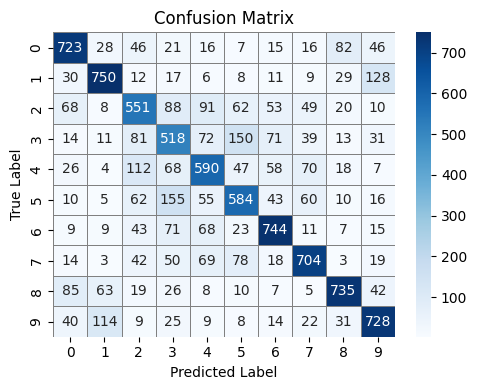

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1000
           1       0.75      0.75      0.75      1000
           2       0.56      0.55      0.56      1000
           3       0.50      0.52      0.51      1000
           4       0.60      0.59      0.59      1000
           5       0.60      0.58      0.59      1000
           6       0.72      0.74      0.73      1000
           7       0.71      0.70      0.71      1000
           8       0.78      0.73      0.75      1000
           9       0.70      0.73      0.71      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



In [9]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_same_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

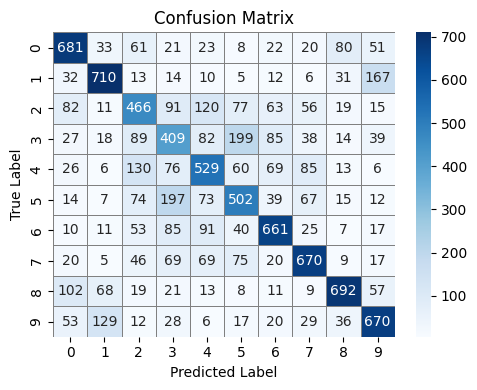

              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1000
           1       0.71      0.71      0.71      1000
           2       0.48      0.47      0.47      1000
           3       0.40      0.41      0.41      1000
           4       0.52      0.53      0.52      1000
           5       0.51      0.50      0.50      1000
           6       0.66      0.66      0.66      1000
           7       0.67      0.67      0.67      1000
           8       0.76      0.69      0.72      1000
           9       0.64      0.67      0.65      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



In [10]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_no_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

In [11]:
baseline_acc = (y_true == y_pred).float().mean().item()
print(f"{100 * baseline_acc:.2f}%")

59.90%


## Experiments - 0.3

In [12]:
C = 10
K = 10
bias = 0.3
encoder_type = 'MLP'
dataset_name = 'CIFAR10'
gammas = [0] + torch.logspace(-5, 1, steps=24).tolist()
device = device

print(gammas)

[0, 9.999999747378752e-06, 1.823348065954633e-05, 3.324597855680622e-05, 6.0618989664362743e-05, 0.00011052951595047489, 0.0002015337668126449, 0.0003674661857075989, 0.0006700187223032117, 0.0012216774048283696, 0.002227542921900749, 0.004061585757881403, 0.007405684795230627, 0.013503140769898891, 0.02462092414498329, 0.04489251226186752, 0.0818546712398529, 0.14924955368041992, 0.27213388681411743, 0.4961947500705719, 0.9047357439994812, 1.6496480703353882, 3.007882595062256, 5.484416484832764, 10.0]


In [13]:
results_matrix3 = run_experiments(C, K, bias, encoder_type, dataset_name, gammas, device)

Trained LAFTR on DP : 1/25.
Trained LAFTR on EO : 1/25.
Trained LAFTR on DP : 2/25.
Trained LAFTR on EO : 2/25.
Trained LAFTR on DP : 3/25.
Trained LAFTR on EO : 3/25.
Trained LAFTR on DP : 4/25.
Trained LAFTR on EO : 4/25.
Trained LAFTR on DP : 5/25.
Trained LAFTR on EO : 5/25.
Trained LAFTR on DP : 6/25.
Trained LAFTR on EO : 6/25.
Trained LAFTR on DP : 7/25.
Trained LAFTR on EO : 7/25.
Trained LAFTR on DP : 8/25.
Trained LAFTR on EO : 8/25.
Trained LAFTR on DP : 9/25.
Trained LAFTR on EO : 9/25.
Trained LAFTR on DP : 10/25.
Trained LAFTR on EO : 10/25.
Trained LAFTR on DP : 11/25.
Trained LAFTR on EO : 11/25.
Trained LAFTR on DP : 12/25.
Trained LAFTR on EO : 12/25.
Trained LAFTR on DP : 13/25.
Trained LAFTR on EO : 13/25.
Trained LAFTR on DP : 14/25.
Trained LAFTR on EO : 14/25.
Trained LAFTR on DP : 15/25.
Trained LAFTR on EO : 15/25.
Trained LAFTR on DP : 16/25.
Trained LAFTR on EO : 16/25.
Trained LAFTR on DP : 17/25.
Trained LAFTR on EO : 17/25.
Trained LAFTR on DP : 18/25.
Tra

## Baseline model - 1.0 MNIST

In [12]:
C = 2
K = 2
bias = 0.999999
dataset_name = 'MNIST'

train_set, test_set_same_bias, test_set_no_bias, test_set_modified_bias = create_datasets(C, K, bias=bias, dataset_name=dataset_name, device=device)

In [13]:
batch_size = 1<<12

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader_same_bias = DataLoader(test_set_same_bias, batch_size=batch_size)

learning_rate = 1e-3
n_epochs = 15
latent_dim = 24

if dataset_name == "MNIST":
    encoder = MLPEncoder(latent_dim).to(device)
    #encoder = ConvEncoderMNIST(latent_dim).to(device)
elif dataset_name == "CIFAR10":
    encoder = ConvEncoderCIFAR(latent_dim).to(device)
    
classifier = Classifier(latent_dim, C=C).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

model = torch.nn.Sequential(encoder, classifier)

In [14]:
# training loop
model.train()

for epoch in range(n_epochs):
    for images, _, labels in train_loader:
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 0.000000
Epoch 2 complete: Loss = 0.000000
Epoch 3 complete: Loss = 0.000000
Epoch 4 complete: Loss = 0.000000
Epoch 5 complete: Loss = 0.000000
Epoch 6 complete: Loss = 0.000000
Epoch 7 complete: Loss = 0.000000
Epoch 8 complete: Loss = 0.000000
Epoch 9 complete: Loss = 0.000000
Epoch 10 complete: Loss = 0.000000
Epoch 11 complete: Loss = 0.000000
Epoch 12 complete: Loss = 0.000000
Epoch 13 complete: Loss = 0.000000
Epoch 14 complete: Loss = 0.000000
Epoch 15 complete: Loss = 0.000000


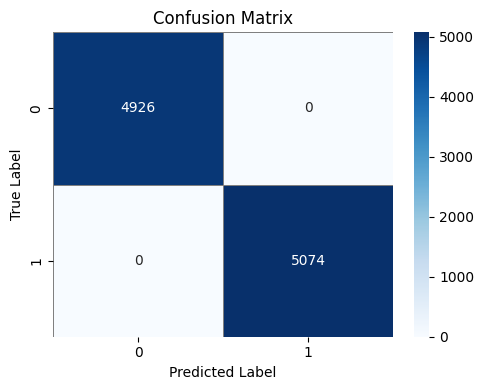

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4926
           1       1.00      1.00      1.00      5074

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

100.00%


In [15]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_same_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/mnist_bias1_baseline_samebias_MLP.npy", baseline_acc)
print(f"{100 * baseline_acc:.2f}%")

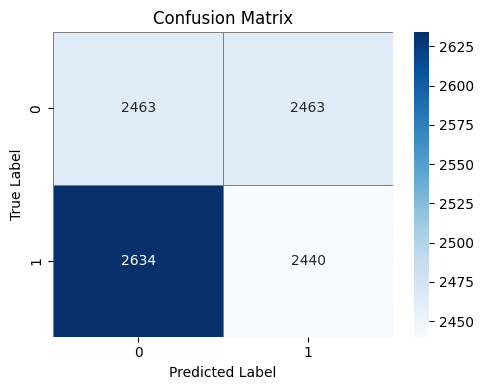

              precision    recall  f1-score   support

           0       0.48      0.50      0.49      4926
           1       0.50      0.48      0.49      5074

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000

49.03%


In [16]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_no_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)


baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/mnist_bias1_baseline_nobias_MLP.npy", baseline_acc)
print(f"{100 * baseline_acc:.2f}%")

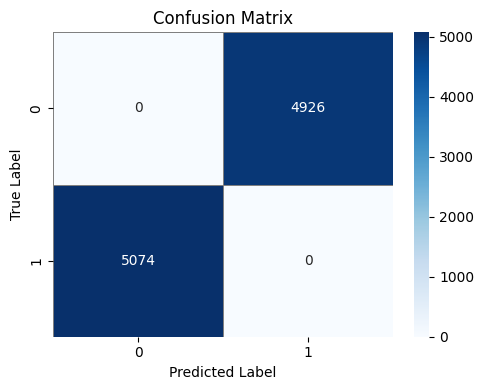

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    4926.0
           1       0.00      0.00      0.00    5074.0

    accuracy                           0.00   10000.0
   macro avg       0.00      0.00      0.00   10000.0
weighted avg       0.00      0.00      0.00   10000.0

0.00%


In [17]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_modified_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)


baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/mnist_bias1_baseline_modifiedbias_MLP.npy", baseline_acc)
print(f"{100 * baseline_acc:.2f}%")

## Experiments - MNIST 1.0

In [18]:
## Experiments - 1.0
C = 2
K = 2
bias = 0.99999
encoder_type = 'MLP'
dataset_name = 'MNIST'
gammas = [0] + torch.logspace(-5, 1, steps=19).tolist()
device = device

print(gammas)


generate_p_y_a(bias, C, K, device)
results_matrix = run_experiments(C, K, bias, encoder_type, dataset_name, gammas, device)

[0, 9.999999747378752e-06, 2.1544346964219585e-05, 4.641588748199865e-05, 9.999999747378752e-05, 0.00021544346236623824, 0.00046415888937190175, 0.0010000000474974513, 0.002154434798285365, 0.004641588777303696, 0.009999999776482582, 0.02154434658586979, 0.04641588777303696, 0.10000000149011612, 0.2154434621334076, 0.46415889263153076, 1.0, 2.1544346809387207, 4.6415886878967285, 10.0]
Trained LAFTR on DP : 1/20.
Trained LAFTR on EO : 1/20.
Trained LAFTR on DP : 2/20.
Trained LAFTR on EO : 2/20.
Trained LAFTR on DP : 3/20.
Trained LAFTR on EO : 3/20.
Trained LAFTR on DP : 4/20.
Trained LAFTR on EO : 4/20.
Trained LAFTR on DP : 5/20.
Trained LAFTR on EO : 5/20.
Trained LAFTR on DP : 6/20.
Trained LAFTR on EO : 6/20.
Trained LAFTR on DP : 7/20.
Trained LAFTR on EO : 7/20.
Trained LAFTR on DP : 8/20.
Trained LAFTR on EO : 8/20.
Trained LAFTR on DP : 9/20.
Trained LAFTR on EO : 9/20.
Trained LAFTR on DP : 10/20.
Trained LAFTR on EO : 10/20.
Trained LAFTR on DP : 11/20.
Trained LAFTR on EO 

In [19]:
np.save("../results/mnist_bias1_MLP.npy", results_matrix)

## Baseline - 1.0 CIFAR-10 (k=2)

In [4]:
C = 10
K = 2
bias = 0.999999
dataset_name = 'CIFAR10'

train_set, test_set_same_bias, test_set_no_bias, test_set_modified_bias = create_datasets(C, K, bias=bias, dataset_name=dataset_name, device=device)

In [5]:
batch_size = 1<<12

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader_same_bias = DataLoader(test_set_same_bias, batch_size=batch_size)

learning_rate = 1e-3
n_epochs = 15
latent_dim = 24

if dataset_name == "MNIST":
    #encoder = MLPEncoder(latent_dim).to(device)
    encoder = ConvEncoderMNIST(in_channels=1)
elif dataset_name == "CIFAR10":
    encoder = ConvEncoderCIFAR(latent_dim).to(device)
    
classifier = Classifier(latent_dim, C=C).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

model = torch.nn.Sequential(encoder, classifier)

In [6]:
# training loop
model.train()

for epoch in range(n_epochs):
    for images, _, labels in train_loader:
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 1.883059
Epoch 2 complete: Loss = 1.725345
Epoch 3 complete: Loss = 1.554408
Epoch 4 complete: Loss = 1.469396
Epoch 5 complete: Loss = 1.377568
Epoch 6 complete: Loss = 1.273006
Epoch 7 complete: Loss = 1.291098
Epoch 8 complete: Loss = 1.214532
Epoch 9 complete: Loss = 1.181385
Epoch 10 complete: Loss = 1.123590
Epoch 11 complete: Loss = 1.201974
Epoch 12 complete: Loss = 1.053481
Epoch 13 complete: Loss = 1.110231
Epoch 14 complete: Loss = 1.029505
Epoch 15 complete: Loss = 0.981620


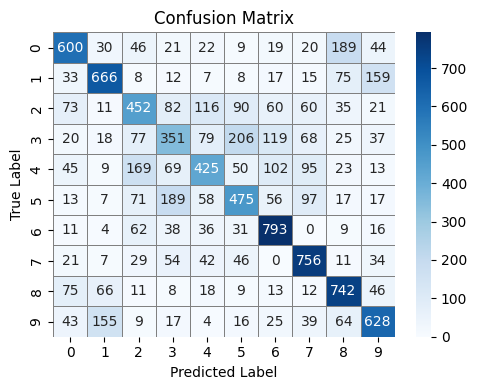

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1000
           1       0.68      0.67      0.68      1000
           2       0.48      0.45      0.47      1000
           3       0.42      0.35      0.38      1000
           4       0.53      0.42      0.47      1000
           5       0.51      0.47      0.49      1000
           6       0.66      0.79      0.72      1000
           7       0.65      0.76      0.70      1000
           8       0.62      0.74      0.68      1000
           9       0.62      0.63      0.62      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000

Baseline acc: 58.88%


In [7]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_same_bias.dataset
y_pred = model_predictor.predict_class(x)

baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/cifar_k2_bias1_baseline_samebias.npy", baseline_acc)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)
model_predictor = Predictor(model=model, N=K, device=device)

print(f"Baseline acc: {100 * baseline_acc:.2f}%")

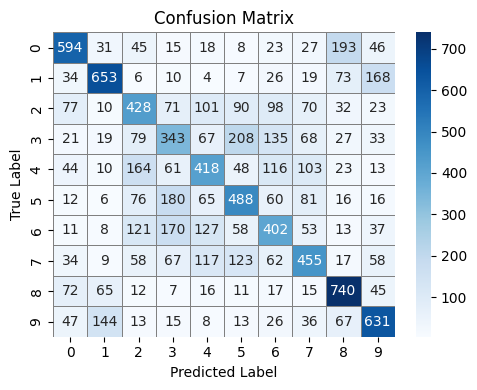

              precision    recall  f1-score   support

           0       0.63      0.59      0.61      1000
           1       0.68      0.65      0.67      1000
           2       0.43      0.43      0.43      1000
           3       0.37      0.34      0.35      1000
           4       0.44      0.42      0.43      1000
           5       0.46      0.49      0.48      1000
           6       0.42      0.40      0.41      1000
           7       0.49      0.46      0.47      1000
           8       0.62      0.74      0.67      1000
           9       0.59      0.63      0.61      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



In [8]:
x, a_true, y_true = test_set_no_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

In [9]:
baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/cifar_k2_bias1_baseline_nobias.npy", baseline_acc)
print(f"Baseline acc: {100 * baseline_acc:.2f}%")

Baseline acc: 51.52%


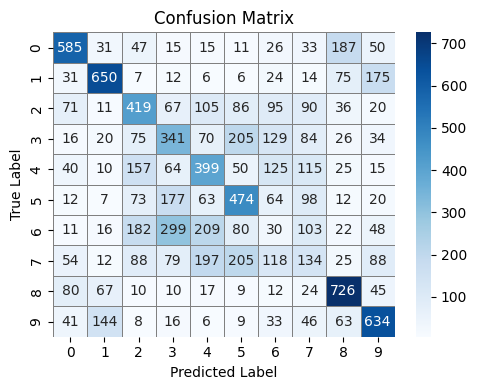

              precision    recall  f1-score   support

           0       0.62      0.58      0.60      1000
           1       0.67      0.65      0.66      1000
           2       0.39      0.42      0.41      1000
           3       0.32      0.34      0.33      1000
           4       0.37      0.40      0.38      1000
           5       0.42      0.47      0.44      1000
           6       0.05      0.03      0.04      1000
           7       0.18      0.13      0.15      1000
           8       0.61      0.73      0.66      1000
           9       0.56      0.63      0.60      1000

    accuracy                           0.44     10000
   macro avg       0.42      0.44      0.43     10000
weighted avg       0.42      0.44      0.43     10000

Baseline acc: 43.92%


In [10]:
x, a_true, y_true = test_set_modified_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/cifar_k2_bias1_baseline_modifiedbias.npy", baseline_acc)
print(f"Baseline acc: {100 * baseline_acc:.2f}%")

## Experiments - 1.0 CIFAR-10 (k=2)

In [ ]:
C = 10
K = 2
bias = 0.99999
encoder_type = 'MLP'
dataset_name = 'CIFAR10'
gammas = [0] + torch.logspace(-5, 1, steps=19).tolist()
device = device

print(gammas)

generate_p_y_a(bias, C, K, device)
results_matrix = run_experiments(C, K, bias, encoder_type, dataset_name, gammas, device)
np.save("../results/cifar_k2_bias1.npy", results_matrix)

## Baseline - 1.0 CIFAR-10 (k=10)

In [5]:
C = 10
K = 10
bias = 0.8
dataset_name = 'CIFAR10'

train_set, test_set_same_bias, test_set_no_bias, test_set_modified_bias = create_datasets(C, K, bias=bias, dataset_name=dataset_name, device=device)
batch_size = 1<<12

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader_same_bias = DataLoader(test_set_same_bias, batch_size=batch_size)

learning_rate = 1e-3
n_epochs = 15
latent_dim = 24

if dataset_name == "MNIST":
    #encoder = MLPEncoder(latent_dim).to(device)
    encoder = ConvEncoderMNIST(in_channels=1)
elif dataset_name == "CIFAR10":
    encoder = ConvEncoderCIFAR(latent_dim).to(device)
    
classifier = Classifier(latent_dim, C=C).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

model = torch.nn.Sequential(encoder, classifier)


In [6]:
# training loop
model.train()

for epoch in range(n_epochs):
    for images, _, labels in train_loader:
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 1.246219
Epoch 2 complete: Loss = 0.939345
Epoch 3 complete: Loss = 0.848523
Epoch 4 complete: Loss = 0.789137
Epoch 5 complete: Loss = 0.734425
Epoch 6 complete: Loss = 0.660579
Epoch 7 complete: Loss = 0.650111
Epoch 8 complete: Loss = 0.575381
Epoch 9 complete: Loss = 0.627803
Epoch 10 complete: Loss = 0.568643
Epoch 11 complete: Loss = 0.576496
Epoch 12 complete: Loss = 0.565597
Epoch 13 complete: Loss = 0.512790
Epoch 14 complete: Loss = 0.524755
Epoch 15 complete: Loss = 0.529561


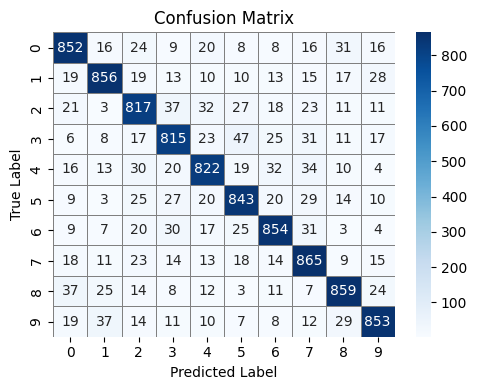

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.87      0.86      0.87      1000
           2       0.81      0.82      0.82      1000
           3       0.83      0.81      0.82      1000
           4       0.84      0.82      0.83      1000
           5       0.84      0.84      0.84      1000
           6       0.85      0.85      0.85      1000
           7       0.81      0.86      0.84      1000
           8       0.86      0.86      0.86      1000
           9       0.87      0.85      0.86      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Baseline acc: 84.36%


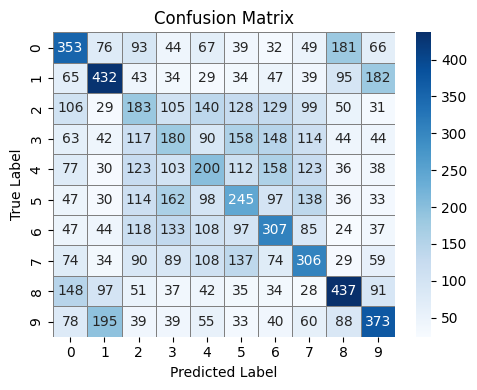

              precision    recall  f1-score   support

           0       0.33      0.35      0.34      1000
           1       0.43      0.43      0.43      1000
           2       0.19      0.18      0.19      1000
           3       0.19      0.18      0.19      1000
           4       0.21      0.20      0.21      1000
           5       0.24      0.24      0.24      1000
           6       0.29      0.31      0.30      1000
           7       0.29      0.31      0.30      1000
           8       0.43      0.44      0.43      1000
           9       0.39      0.37      0.38      1000

    accuracy                           0.30     10000
   macro avg       0.30      0.30      0.30     10000
weighted avg       0.30      0.30      0.30     10000

Baseline acc: 30.16%


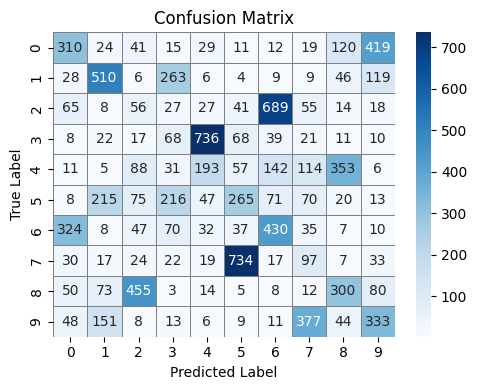

              precision    recall  f1-score   support

           0       0.35      0.31      0.33      1000
           1       0.49      0.51      0.50      1000
           2       0.07      0.06      0.06      1000
           3       0.09      0.07      0.08      1000
           4       0.17      0.19      0.18      1000
           5       0.22      0.27      0.24      1000
           6       0.30      0.43      0.35      1000
           7       0.12      0.10      0.11      1000
           8       0.33      0.30      0.31      1000
           9       0.32      0.33      0.33      1000

    accuracy                           0.26     10000
   macro avg       0.25      0.26      0.25     10000
weighted avg       0.25      0.26      0.25     10000

Baseline acc: 25.62%


In [7]:
model_predictor = Predictor(model=model, N=K, device=device)

x, a_true, y_true = test_set_same_bias.dataset
y_pred = model_predictor.predict_class(x)

baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/cifar_k10_bias1_baseline_samebias_CCE.npy", baseline_acc)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)
print(f"Baseline acc: {100 * baseline_acc:.2f}%")


model_predictor = Predictor(model=model, N=K, device=device)
x, a_true, y_true = test_set_no_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/cifar_k10_bias1_baseline_nobias_CCE.npy", baseline_acc)
print(f"Baseline acc: {100 * baseline_acc:.2f}%")


model_predictor = Predictor(model=model, N=K, device=device)
x, a_true, y_true = test_set_modified_bias.dataset
y_pred = model_predictor.predict_class(x)

model_predictor.plot_confusion_matrix(y_true, y_pred)
model_predictor.print_classification_report(y_true, y_pred)

baseline_acc = (y_true == y_pred).float().mean().item()
np.save("../results/cifar_k10_bias1_baseline_modifiedbias_CCE.npy", baseline_acc)
print(f"Baseline acc: {100 * baseline_acc:.2f}%")

## Experiments - 1.0 CIFAR-10 (k=10)

In [8]:
C = 10
K = 10
bias = 0.8
encoder_type = 'MLP'
dataset_name = 'CIFAR10'
gammas = [0] + torch.logspace(-5, 1, steps=19).tolist()
device = device

print(gammas)

generate_p_y_a(bias, C, K, device)
results_matrix = run_experiments(C, K, bias, encoder_type, dataset_name, gammas, device)
np.save("../results/cifar_k10_bias1_CCE.npy", results_matrix)


[0, 9.999999747378752e-06, 2.1544346964219585e-05, 4.641588748199865e-05, 9.999999747378752e-05, 0.00021544346236623824, 0.00046415888937190175, 0.0010000000474974513, 0.002154434798285365, 0.004641588777303696, 0.009999999776482582, 0.02154434658586979, 0.04641588777303696, 0.10000000149011612, 0.2154434621334076, 0.46415889263153076, 1.0, 2.1544346809387207, 4.6415886878967285, 10.0]
Trained LAFTR on DP : 1/20.
Trained LAFTR on EO : 1/20.
Trained LAFTR on DP : 2/20.
Trained LAFTR on EO : 2/20.
Trained LAFTR on DP : 3/20.
Trained LAFTR on EO : 3/20.
Trained LAFTR on DP : 4/20.
Trained LAFTR on EO : 4/20.
Trained LAFTR on DP : 5/20.
Trained LAFTR on EO : 5/20.
Trained LAFTR on DP : 6/20.
Trained LAFTR on EO : 6/20.
Trained LAFTR on DP : 7/20.
Trained LAFTR on EO : 7/20.
Trained LAFTR on DP : 8/20.
Trained LAFTR on EO : 8/20.
Trained LAFTR on DP : 9/20.
Trained LAFTR on EO : 9/20.
Trained LAFTR on DP : 10/20.
Trained LAFTR on EO : 10/20.
Trained LAFTR on DP : 11/20.
Trained LAFTR on EO 